# Finding Similar Neighbourhoods -Toronto
###### -Harshul Varma

***

## Table of Contents

[1.0 Introduction](#introduction)<br>
[2.0 Dataset](#dataset)<br>
&nbsp;&nbsp;[2.1 Importing Libraries](#2.1)<br>
&nbsp;&nbsp;[2.2 Toronto Postal Code Borough and Neighbourhood Data - Scraping, Cleaning, Analysing and Preparing](#2.2)<br>
&nbsp;&nbsp;[2.3 Getting venues for each Postal area - Foursquare API](#2.3)<br>
[3.0 Finding Most Common Venues in each Postal Area](#3.0)<br>
[4.0 Clustering Postal Areas : K-means](#4.0)<br>
[5.0 What venues are the most important? - Decision Tree](#5.0)<br>
[6.0 Which Neighbourhood is the most similar?](#6.0)<br>

***

## 1.0 Introduction <a id='introduction'></a>

Toronto is one of the major metropolitan cities and Canada with a population of ~2.7 million spread across 12 Boroughs, 180 Postal Code (FSA), and 210 Neighbourhoods. Lately, the rise in population, more job opportunities and ever-increasing Toronto rent forces a lot of recent graduates and young adults (like me) to rent new condos around the Toronto area. Since every people have their preferences of the area, they want to live in based on amenities such as food, recreation, nightlife etc. available in the neighbourhoods, this project will aim to find similar neighbourhoods that people prefer to make their move easier. This project also can be used by real estate agents to understand their client needs and make recommendations based on a concrete data. Furthermore, the model can be used to find similar neighbourhoods in different cities to make moving easier, for example a person moving from Toronto to Montreal can find a similar neighbourhood.

***

## 2.0 Data <a id='dataset'></a>

In order to build a robust model, I will be using various data sources, and most of the project time will be spent on collecting, cleaning and preparing data. The following data sets have been collected or scraped from websites:
- Toronto Postal Codes and respective Neighbourhoods and Borough (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) 
- Toronto Postal Codes boundaries (https://github.com/ag2816/Visualizations/tree/master/data)
- Toronto Latitude and Longitude for each Postal area (Python Geocoder)
- Toronto Population and Dwelling counts for each Postal area (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0) 
- Different Categories of Venues available in each area (Foursquare API)

Although population and dwelling data will be considered but will be dropped in case it skews the model a lot. 


### 2.1 Importing Libraries <a id='2.1'></a>

In [93]:
#Loading Libraries
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq 

import numpy as np
import pandas as pd
import folium

from geopy.geocoders import Nominatim
import requests

from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

###  2.2 Toronto Postal Code Borough and Neighbourhood Data - Scraping, Cleaning, Analysing and Preparing <a id='2.2'></a>

 Let's start by scraping GTA borough and neighbourhood data from wikipedia page. We will use BeautifulSoup library for this.


In [94]:
#Reading the url
my_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
uClient = uReq(my_url)
page_html = uClient.read()
uClient.close()

In [95]:
#parsing the html page
page_soup = soup(page_html,"html.parser")

In [96]:
#Converting the table to a list
table = page_soup.find("table",{"class":"wikitable sortable"})
table_rows = table.find_all('tr')

data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text.strip() for i in td if i.text.strip()]
    if row:
        data.append(row)

 Now that we have converted the tabel to a list, we can form a dataframe using pandas and start cleaning up our data.

In [97]:
df = pd.DataFrame(data, columns=["PostalCode", "Borough", "Neighbourhood"])

In [98]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [99]:
print('Toronto has {} Boroughs, {} Postal Code Areas, and {} Neighbourhoods'.format(df.Borough.nunique(),df.PostalCode.nunique(),df.Neighbourhood.nunique()))

Toronto has 12 Boroughs, 180 Postal Code Areas, and 210 Neighbourhoods


In [100]:
df = df[df.Borough != "Not assigned"]
df = df.groupby(['PostalCode','Borough'], as_index=False, sort=False).agg(','.join)
df['Neighbourhood'] = df['Neighbourhood'].replace("Not assigned",df['Borough'])

In [101]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


Now let us add the co-ordinates, population and dwellings for each postal area

Location data - 

In [102]:
geo_url = 'http://cocl.us/Geospatial_data'
geodf = pd.read_csv(geo_url)

Population and Dwellings data -

In [103]:
to_pop = pd.read_csv('toronto_data/to_pop.csv',encoding='windows-1252')

In [104]:
to_pop = to_pop.drop(columns=['Geographic name','Province or territory','Incompletely enumerated Indian reserves and Indian settlements, 2016','Private dwellings occupied by usual residents, 2016'])
to_pop.columns = ['PostalCode','Population','Dwellings']

In [105]:
newdf = pd.merge(df,geodf,left_on='PostalCode',right_on='Postal Code')
newdf = newdf.drop(columns='Postal Code')

Let's see our data with co-ordinates added.

In [106]:
newdf.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


Adding Population and Dwellings data-

In [107]:
final_df = pd.merge(newdf,to_pop,left_on='PostalCode',right_on='PostalCode')

In [108]:
final_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Population,Dwellings
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615.0,13847.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443.0,6299.0
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636,41078.0,24186.0
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763,21048.0,8751.0
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,10.0,6.0


Finally let's check if our datframes have any null values.

In [109]:
check1 = final_df.isnull().any()
check2 = newdf.isnull().any()

In [110]:
print(check1)
print(check2)

PostalCode       False
Borough          False
Neighbourhood    False
Latitude         False
Longitude        False
Population       False
Dwellings        False
dtype: bool
PostalCode       False
Borough          False
Neighbourhood    False
Latitude         False
Longitude        False
dtype: bool


We are good to proceed!

## 2.3 Getting venues for each Postal area - Foursquare API <a id='2.3'></a>

Entering Foursquare API credentials-

In [111]:
CLIENT_ID = ''
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = '100'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('LIMIT:' + LIMIT)

Your credentails:
CLIENT_ID: 251M3SPKVC3S5IXONYPWKIBQCZEFR0PKRSJW5RGCGC2EOFMT
CLIENT_SECRET:IWTYY1MGWSRJTF0V2BPNQGKFME0SOOIFSMCDUXYIELBHLKLZ
LIMIT:100


Foursquare API returns very specific categories, but for our case we need generalized categories such as Food, Hotel, Nightlife etc. Below is a function that will return the parent category for each venue.
More about foursquare API categories can be seen here: https://developer.foursquare.com/docs/resources/categories

In [112]:
url = "https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION )
response = requests.get(url)
cats = {}

def crawl(catlist=response.json()['response'], parents=[]):
    for c in catlist['categories']:
        cats[c['name']] = parents + [c['name']]
        crawl(c, parents + [c['name']])
        
crawl()

Function to get nearby venues for given co-ordinates:

In [113]:
def getNearbyVenues(fsa, latitudes, longitudes, radius=1200):
    
    venues_list=[]
    for fsa, lat, lng in zip(fsa, latitudes, longitudes):
        

            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            fsa, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            cats[v['venue']['categories'][0]['name']][0]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                   'Venue General Category']
    
    return(nearby_venues)

Retrieving venues for toronto's postal ares -

(Note: We are using the dataframe without population and dwellings as it was skewing results for our final model)

In [114]:
toronto_venues = getNearbyVenues(fsa=newdf['PostalCode'],
                                   latitudes=newdf['Latitude'],
                                   longitudes=newdf['Longitude']
                                  )

Let's look at the retireved venues table-

In [115]:
toronto_venues.head()

,PostalCode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue General Category
0,M3A,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,Food
1,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,Outdoors & Recreation
2,M3A,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,Outdoors & Recreation
3,M3A,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café,Food
4,M3A,43.753259,-79.329656,A&W Canada,43.760643,-79.326865,Fast Food Restaurant,Food


In [116]:
print('{} venues were retrieved and stored'.format(toronto_venues.shape[0]))

5742 venues were retrieved and stored


In [117]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Toronto postal area boundaries - 

In [118]:
to_geo = 'toronto_data/torontogeo.geojson'

Visualising all the Venues retrieved:
    
(Since the file is too big to display on python, it is saved and a screen shot can be seen in the report an presentation)

In [119]:
to_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.GeoJson(
    to_geo,
    name='geojson'
).add_to(to_venues)

for lat, lng, venue in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(to_venues)  
    
to_venues.save('to_venues.html')

## 3.0 Finding Most Common Venues in each Postal Area <a id='3.0'></a>

We start by converting each venue's general category to a one hot vector and see how many general venue categories are present in each postal area.

In [120]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(toronto_venues[['Venue General Category']], prefix="", prefix_sep="")

# add other columns back to the dataframe
df_venues_onehot['PostalCode'] = toronto_venues['PostalCode']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_grouped = df_venues_onehot.groupby(['PostalCode']).sum().reset_index()

df_venues_grouped.head()

,PostalCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,1,0,11,0,1,0,0,7,1
1,M1C,0,0,3,0,1,0,0,0,0
2,M1E,0,0,14,1,2,0,0,11,0
3,M1G,0,0,12,0,1,0,0,7,0
4,M1H,0,0,29,0,4,0,0,7,2


Function to return most common venues for each area - 

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

We will only store and use Top 5 most common venue categories

In [122]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['PostalCode'] = df_venues_grouped['PostalCode']

# counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [123]:
df_common_venues.head()

,PostalCode,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5
0,M1B,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Residence
1,M1C,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Residence
2,M1E,Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Travel & Transport
3,M1G,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence
4,M1H,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence


## 4.0 Clustering Postal Areas : K-means <a id='4.0'></a>

Firstly the one hot matrix will be normalized -

In [124]:
# normalize over all columns except the 'PostalCode' column.
collist = df_venues_grouped.columns.tolist()
collist.remove('PostalCode')
df_venues_grouped[collist] = df_venues_grouped[collist].div(df_venues_grouped.sum(axis=1), axis=0)

df_venues_grouped.head()

,PostalCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,0.047619,0.0,0.523810,0.000000,0.047619,0.0,0.0,0.333333,0.047619
1,M1C,0.000000,0.0,0.750000,0.000000,0.250000,0.0,0.0,0.000000,0.000000
2,M1E,0.000000,0.0,0.500000,0.035714,0.071429,0.0,0.0,0.392857,0.000000
3,M1G,0.000000,0.0,0.600000,0.000000,0.050000,0.0,0.0,0.350000,0.000000
4,M1H,0.000000,0.0,0.690476,0.000000,0.095238,0.0,0.0,0.166667,0.047619


In [125]:
df_grouped_clustering = df_venues_grouped.drop('PostalCode', 1)

Let us use the normalized matrix for k-means clustering. We will analyse which k value return the most accurate result.

maximum is 0.35101675838297725, which occurs at k=2


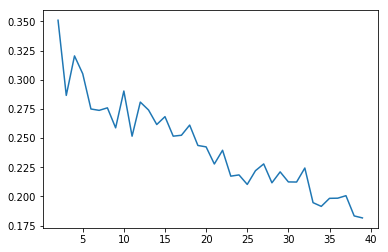

In [126]:
START = 2
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering, but drop the first column (buurtcode)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_grouped_clustering)
    
    scores.append(metrics.silhouette_score(df_grouped_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

We can see the most optimal k value is 2. But since 2 clusters will be too less for our analysis we will look for another value. By inspecting the plot and using elbow method we see k=14 is a good choice

In [127]:
kclusters = 14

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([ 4,  9,  4,  4, 12,  8, 11, 11, 13,  3, 12,  8, 12, 12, 12,  0,  6,
       13,  4, 13,  3, 12,  1,  7,  0,  2,  1,  0, 13,  1, 13,  7, 13, 11,
       13, 13,  0,  5,  4, 13,  1,  1,  5,  5,  7,  7,  0,  1,  7,  8, 13,
        5,  8,  8,  8,  8,  5,  8, 10, 10, 10, 10, 12,  7,  7,  8,  8,  5,
        3,  8, 10,  4,  0,  0,  4,  8,  5,  5,  8,  0,  4, 13,  1,  5, 12,
        8,  1,  5,  7, 13,  0,  9,  0,  2, 13,  2,  2,  2, 13,  7,  4,  4,
       11])

In [128]:
# add clustering labels
df_common_venues.insert(0, 'Cluster Labels', kmeans.labels_)

Let's finally add everything togather into one matrix

In [129]:
toronto_merged = newdf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = pd.merge(df_common_venues,toronto_merged,left_on='PostalCode', right_on='PostalCode')

toronto_merged = toronto_merged[pd.notnull(toronto_merged['Cluster Labels'])]
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head()

,Cluster Labels,PostalCode,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Borough,Neighbourhood,Latitude,Longitude
0,4,M1B,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Residence,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,9,M1C,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Residence,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,4,M1E,Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,4,M1G,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Scarborough,Woburn,43.770992,-79.216917
4,12,M1H,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Scarborough,Cedarbrae,43.773136,-79.239476


Visualising Toronto Postal area clusters - 

In [130]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10) 
 
folium.Choropleth(
    geo_data=to_geo,
    name='Toronto FSA Clusters',
    data=toronto_merged,
    columns=['PostalCode', 'Cluster Labels'],
    key_on='feature.properties.CFSAUID',
    fill_color = 'Set3'
).add_to(map_clusters) 

map_clusters

In [131]:
clusters = toronto_merged.groupby(['Cluster Labels'], as_index=False, sort=False).agg(','.join)
clusters = clusters.drop(columns = ['Common Venue 1','Common Venue 2','Common Venue 3','Common Venue 4','Common Venue 5','Borough'])
clusters['Count'] = toronto_merged.groupby('Cluster Labels')['PostalCode'].count()
clusters.columns = ['Cluster Labels','Similar Postal Areas','Similar Neighbourhoods','Number of Postal Areas']

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000
display(clusters)

,Cluster Labels,Similar Postal Areas,Similar Neighbourhoods,Number of Postal Areas
0,4,"M1B,M1E,M1G,M2J,M4G,M6A,M6E,M6M,M9R,M9V","Rouge,Malvern,Guildwood,Morningside,West Hill,Woburn,Fairview,Henry Farm,Oriole,Leaside,Lawrence Heights,Lawrence Manor,Caledonia-Fairbanks,Del Ray,Keelesdale,Mount Dennis,Silverthorn,Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips,Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",10
1,9,"M1C,M8Y","Highland Creek,Rouge Hill,Port Union,Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea",8
2,12,"M1H,M1P,M1S,M1T,M1V,M2M,M5M,M6S","Cedarbrae,Dorset Park,Scarborough Town Centre,Wexford Heights,Agincourt,Clarks Corners,Sullivan,Tam O'Shanter,Agincourt North,L'Amoreaux East,Milliken,Steeles East,Newtonbrook,Willowdale,Bedford Park,Lawrence Manor East,Runnymede,Swansea",5
3,8,"M1J,M1R,M4V,M4Y,M5A,M5B,M5C,M5G,M5R,M5S,M5W,M6G,M6K,M7A","Scarborough Village,Maryvale,Wexford,Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West,Church and Wellesley,Harbourfront,Regent Park,Ryerson,Garden District,St. James Town,Central Bay Street,The Annex,North Midtown,Yorkville,Harbord,University of Toronto,Stn A PO Boxes 25 The Esplanade,Christie,Brockton,Exhibition Place,Parkdale Village,Queen's Park",3
4,11,"M1K,M1L,M3N,M9W","East Birchmount Park,Ionview,Kennedy Park,Clairlea,Golden Mile,Oakridge,Downsview Northwest,Northwest",10
5,13,"M1M,M2H,M2K,M3H,M3K,M3M,M4A,M4B,M4H,M4W,M6N,M8W,M9B,M9N","Cliffcrest,Cliffside,Scarborough Village West,Hillcrest Village,Bayview Village,Bathurst Manor,Downsview North,Wilson Heights,CFB Toronto,Downsview East,Downsview Central,Victoria Village,Woodbine Gardens,Parkview Hill,Thorncliffe Park,Rosedale,The Junction North,Runnymede,Alderwood,Long Branch,Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park,Weston",10
6,3,"M1N,M2L,M5V","Birch Cliff,Cliffside West,Silver Hills,York Mills,CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",1
7,0,"M1W,M2R,M3C,M4C,M4R,M6B,M6C,M6L,M8X,M8Z","L'Amoreaux West,Steeles West,Willowdale West,Flemingdon Park,Don Mills South,Woodbine Heights,North Toronto West,Glencairn,Humewood-Cedarvale,Maple Leaf Park,North Park,Upwood Park,The Kingsway,Montgomery Road,Old Mill North,Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor",9
8,6,M1X,Upper Rouge,14
9,1,"M2N,M3B,M3J,M4J,M4K,M4S,M6P,M7R","Willowdale South,Don Mills North,Northwood Park,York University,East Toronto,The Danforth West,Riverdale,Davisville,High Park,The Junction South,Canada Post Gateway Processing Centre",2


## 5.0 What venues are the most important? - Decision Tree <a id='5.0'></a>

In order to determine which Neighbourhood/Postal Area is the most similar to the one user is currently living in, we will use a Decision Tree to find the most important features (venues)

Let's start by forming our features matrix (X) - Venue One Hot Values for each Postal Area  and labels matrix (y) - Cluster label for each Postal Area

In [132]:
X = df_venues_onehot.groupby(['PostalCode']).sum().reset_index().drop(['PostalCode'],axis=1)


In [133]:
Y = toronto_merged['Cluster Labels']

In [134]:
clf = tree.DecisionTreeClassifier(criterion='entropy' )
clf = clf.fit(X, Y)

Let's view the top features in Toronto

In [135]:
df_topfeatures = pd.DataFrame({'Feature': X.columns.values, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False).head().reset_index()
df_topfeatures = df_topfeatures.drop(columns='index')
df_topfeatures

,Feature,Importance
0,Food,0.359725
1,Outdoors & Recreation,0.185753
2,Shop & Service,0.164555
3,Arts & Entertainment,0.137789
4,Travel & Transport,0.085387


Not a surprise that Toronto loves Food! Thanks to the multicultural diverse population.

## 6.0 Which Neighbourhood is the most similar? <a id='6.0'></a>

For this case, we will use the M5V Postal Areas which happens to be the area I currenlty live in.

In [136]:
toronto_merged[toronto_merged['PostalCode']=='M5V']

,Cluster Labels,PostalCode,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Borough,Neighbourhood,Latitude,Longitude
68,3,M5V,Outdoors & Recreation,Food,Travel & Transport,Nightlife Spot,Shop & Service,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",43.628947,-79.39442


Above is the information for M5V Postal Area, Let us use our Tree model to find the most similar Areas to M5V

In [137]:
#M5V is at row 68
CurrentFSA = df_venues_grouped.loc[68,:].drop('PostalCode')
toronto_merged['dist_CurrentFSA'] = df_venues_grouped[df_venues_grouped.columns[1:]].apply(lambda x: sum((CurrentFSA - x)**2)**.5, axis=1)
top5 = toronto_merged.sort_values(by='dist_CurrentFSA').head(6)
top5

,Cluster Labels,PostalCode,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Borough,Neighbourhood,Latitude,Longitude,dist_CurrentFSA
68,3,M5V,Outdoors & Recreation,Food,Travel & Transport,Nightlife Spot,Shop & Service,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",43.628947,-79.394420,0.000000
20,3,M2L,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,North York,"Silver Hills,York Mills",43.757490,-79.374714,0.133333
9,3,M1N,Outdoors & Recreation,Food,Shop & Service,College & University,Travel & Transport,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.224285
35,13,M4B,Food,Outdoors & Recreation,Shop & Service,Travel & Transport,Nightlife Spot,East York,"Woodbine Gardens,Parkview Hill",43.706397,-79.309937,0.372926
8,13,M1M,Food,Outdoors & Recreation,Shop & Service,Nightlife Spot,Travel & Transport,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0.396688
23,7,M2P,Food,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence,North York,York Mills West,43.752758,-79.400049,0.409536


let us visualise the areas using a choropleth map categorised by the "Most Similar to M5V", The more 'Red' the more similar, the more 'Green' the further the neighbourhood venues.

In [138]:
dist_map = folium.Map(location=[latitude, longitude],zoom_start=10)


folium.Choropleth(
    geo_data=to_geo,
    name='Distance to Current FSA',
    data=toronto_merged,
    columns=['PostalCode', 'dist_CurrentFSA'],
    key_on='feature.properties.CFSAUID',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Distance to Current FSA'
).add_to(dist_map)

dist_map

Finally Let's see what venues there are in common and we can make our Final Choice from the top recommendations!

In [139]:
features = df_topfeatures['Feature'].values.tolist()
pd.merge(top5, df_venues_onehot.groupby('PostalCode').sum()[features], on='PostalCode')[ ['PostalCode'] + df_topfeatures['Feature'].values.tolist()]


,PostalCode,Food,Outdoors & Recreation,Shop & Service,Arts & Entertainment,Travel & Transport
0,M5V,9,17,0,1,2
1,M2L,3,6,1,0,1
2,M1N,6,7,2,1,0
3,M4B,13,10,8,0,2
4,M1M,10,7,6,0,0
5,M2P,18,9,5,0,2


##### For future, this model can be used to compare postal areas between cities, for eg, if someone wants to move from Toronto to Montreal in a similar Neighbourhood.